# Washington DC Biking data | Hourly Bike Count Prediction
MBD O-1-5

### Notebook preperation

In [8]:
# Imports
%matplotlib inline


from My_Functions import * 
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from collections import defaultdict

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score,roc_curve
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict,validation_curve
from sklearn.ensemble import RandomForestRegressor


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler,PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression,LinearRegression, OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split , TimeSeriesSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from pandas import DataFrame 
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.simplefilter(action='ignore')
random_seed = 1234

In [9]:
# To automatically reload the function file 
%load_ext autoreload
%aimport My_Functions
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Exploration

In [10]:
# Data Import
daily_raw_data = read_data('day.csv')
hourly_raw_data=read_data('hour.csv')

In [4]:
daily_raw_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [5]:
daily_raw_data.isnull().any()

instant       False
dteday        False
season        False
yr            False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

In [6]:
daily_raw_data.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

### DAILY DATA visuals

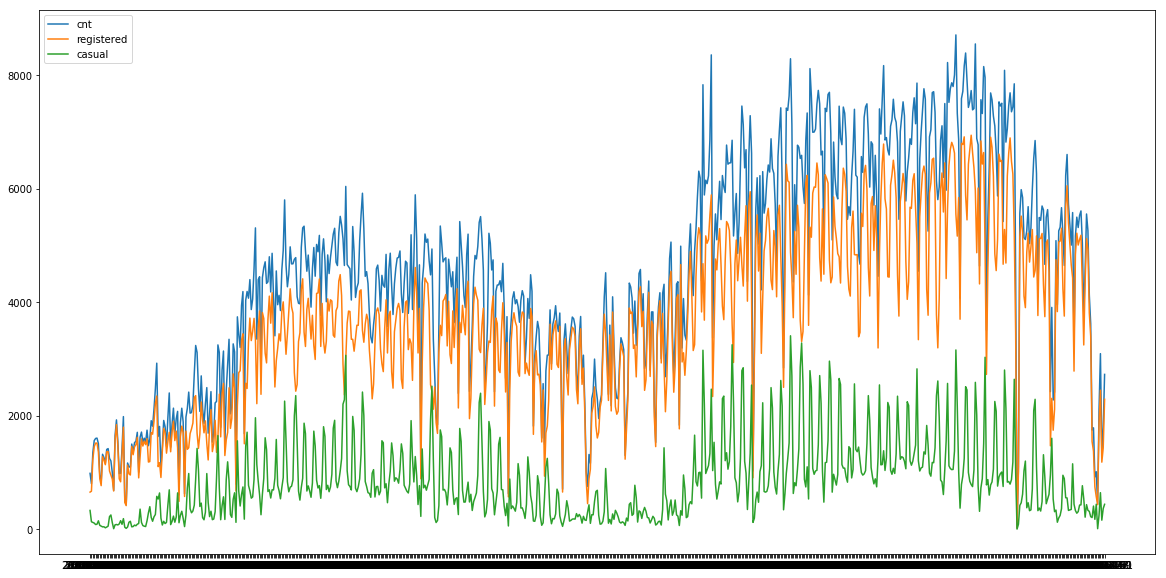

In [7]:
plt.figure(figsize=(20,10))
plt.plot(daily_raw_data['dteday'],daily_raw_data['cnt'])
plt.plot(daily_raw_data['dteday'],daily_raw_data['registered'])
plt.plot(daily_raw_data['dteday'],daily_raw_data['casual'])
plt.legend(['cnt', 'registered', 'casual'], loc='upper left')
plt.show()

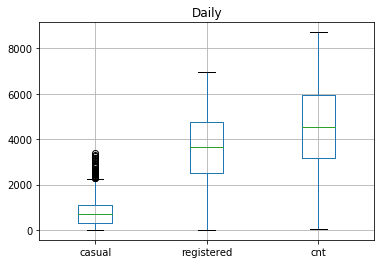

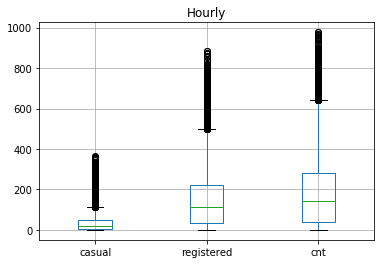

In [8]:
daily_raw_data.boxplot(column = ['casual','registered','cnt'])
plt.title('Daily')
plt.show()
hourly_raw_data.boxplot(column = ['casual','registered','cnt'])
plt.title('Hourly')
plt.show()

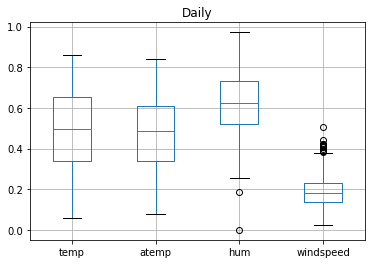

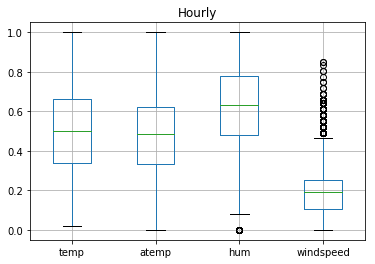

In [9]:
daily_raw_data.boxplot(column = ['temp','atemp','hum','windspeed'])
plt.title('Daily')
plt.show()
hourly_raw_data.boxplot(column = ['temp','atemp','hum','windspeed'])
plt.title('Hourly')
plt.show()

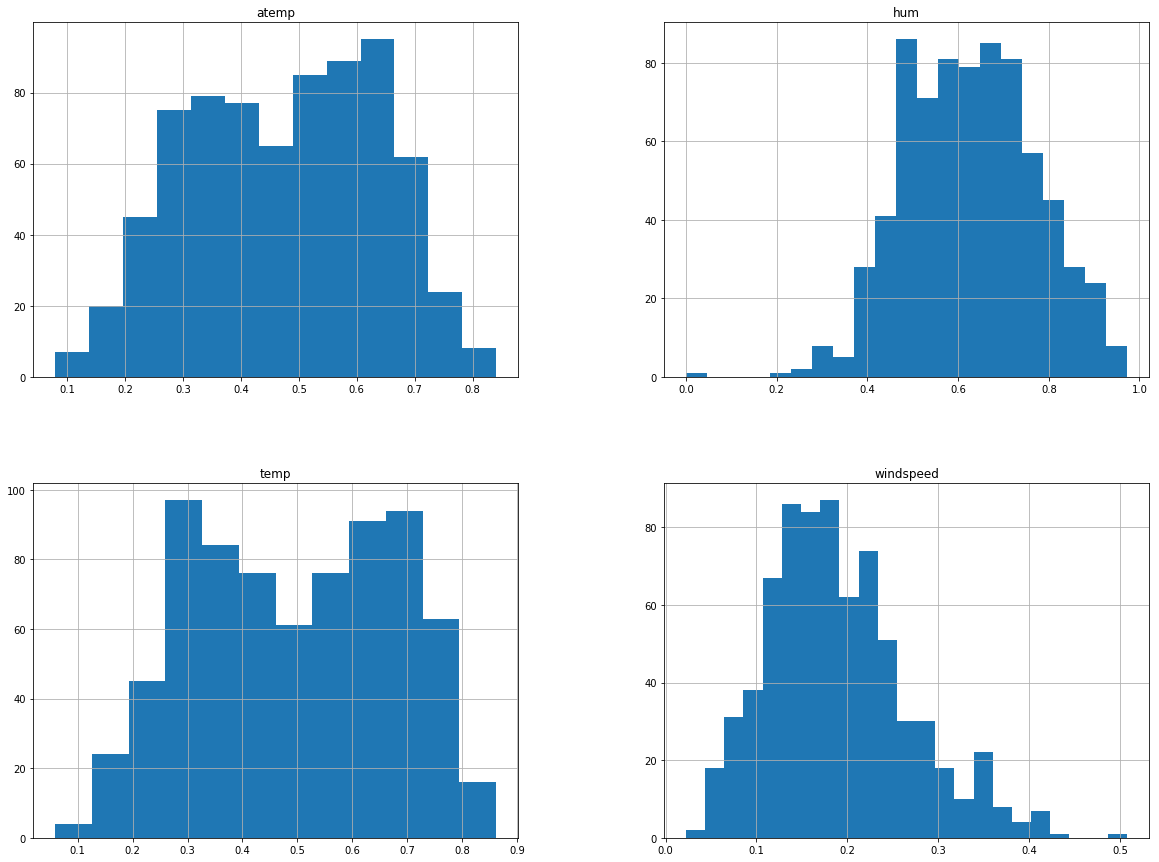

In [10]:
num_bins = 'auto'
to_hist = ['atemp','temp','hum','windspeed']
daily_raw_data[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()

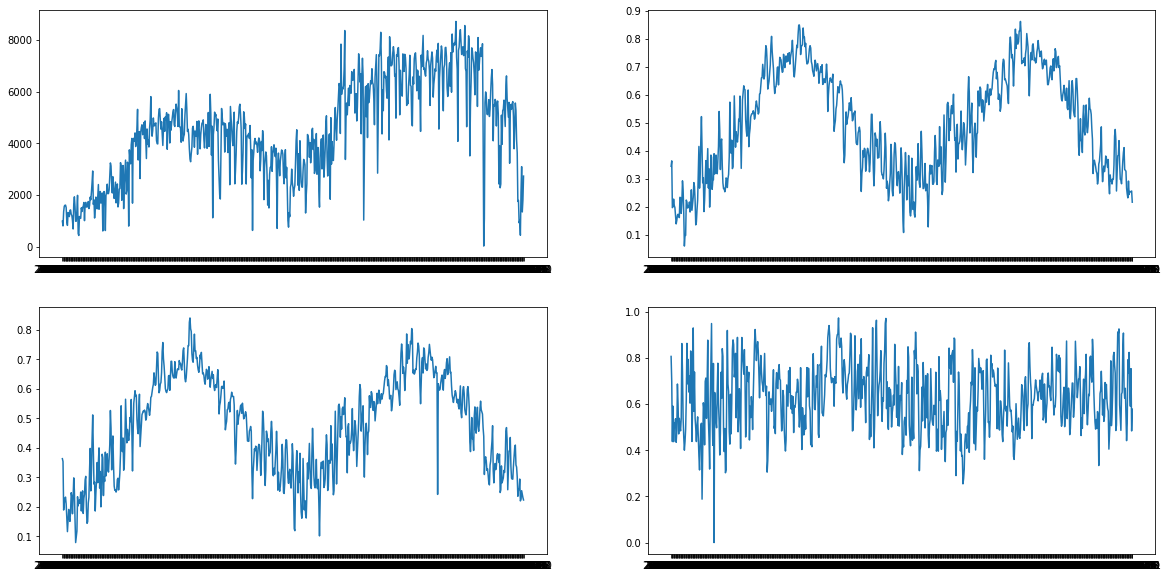

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(2,2, 1)
plt.plot(daily_raw_data['dteday'],daily_raw_data['cnt'])
plt.subplot(2, 2, 2)
plt.plot(daily_raw_data['dteday'],daily_raw_data['temp'])
plt.subplot(2, 2, 3)
plt.plot(daily_raw_data['dteday'],daily_raw_data['atemp'])
plt.subplot(2, 2, 4)
plt.plot(daily_raw_data['dteday'],daily_raw_data['hum'])

### HOURLY DATA visuals

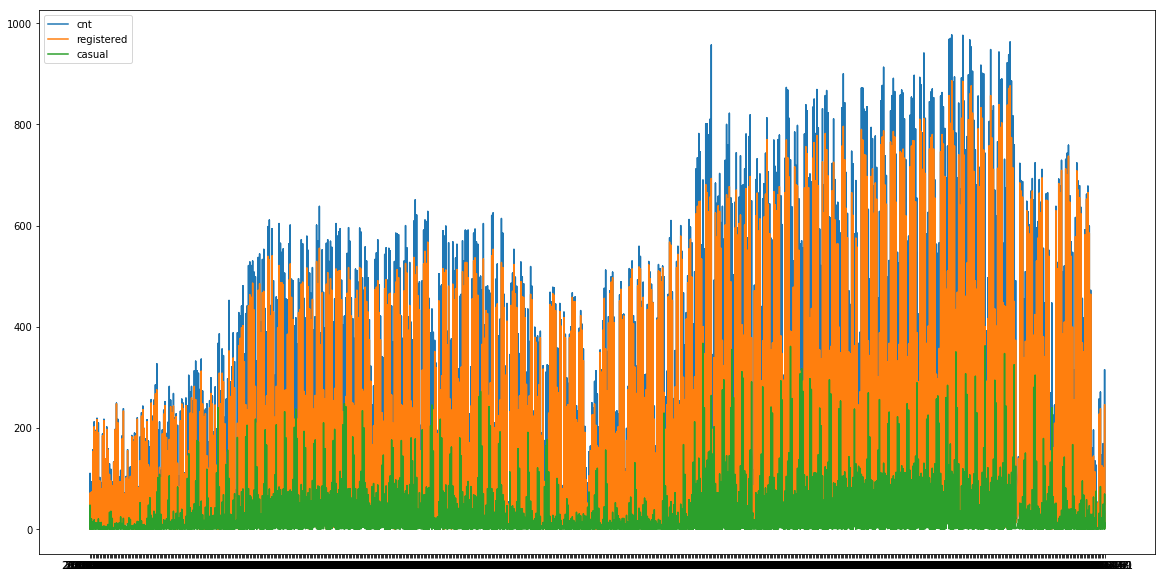

In [12]:
plt.figure(figsize=(20,10))
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['cnt'])
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['registered'])
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['casual'])
plt.legend(['cnt', 'registered', 'casual'], loc='upper left')
plt.show()

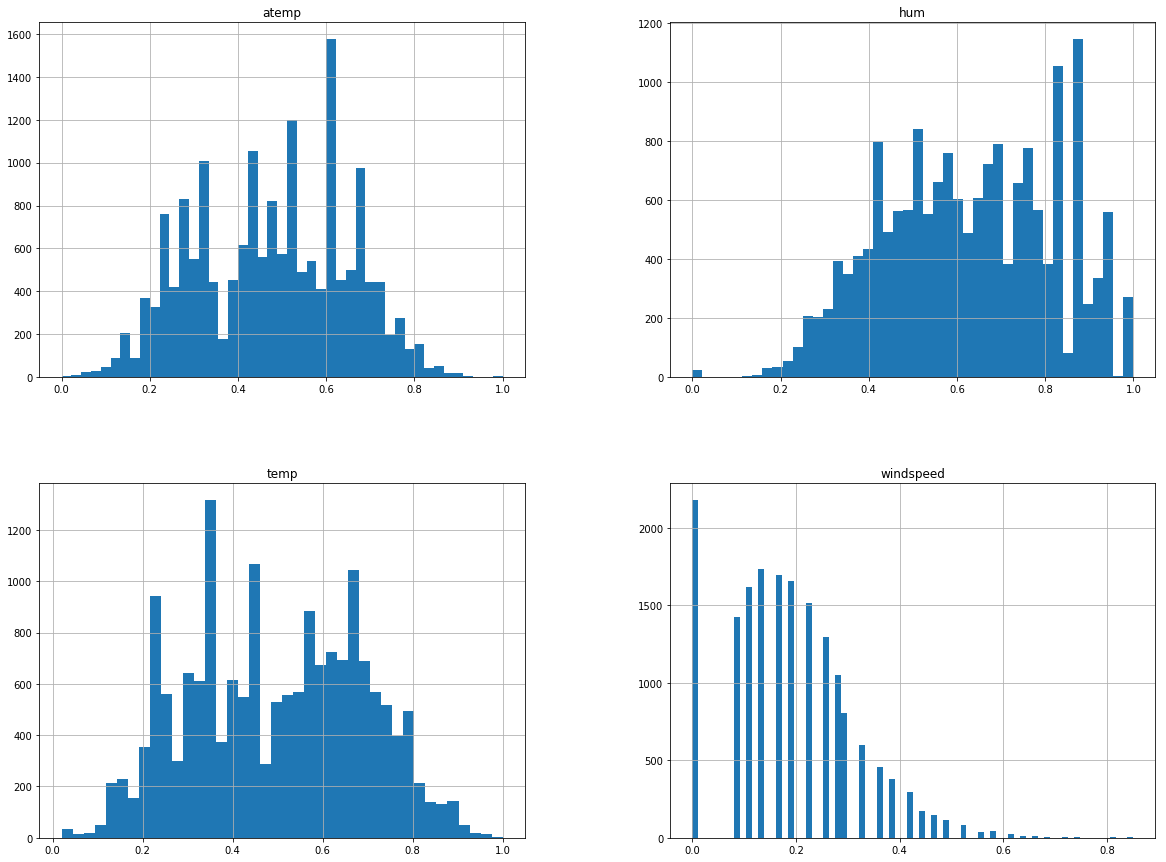

In [13]:

num_bins = 'auto'
to_hist = ['atemp','temp','hum','windspeed']
hourly_raw_data[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()

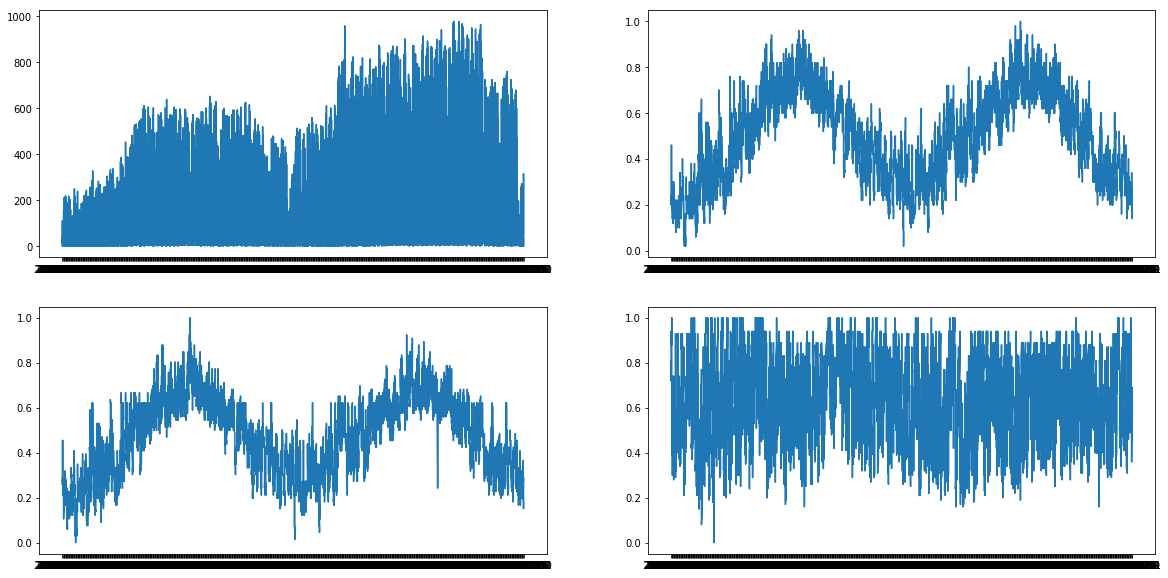

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(2,2, 1)
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['cnt'])
plt.subplot(2, 2, 2)
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['temp'])
plt.subplot(2, 2, 3)
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['atemp'])
plt.subplot(2, 2, 4)
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['hum'])

### Correlation Matrix

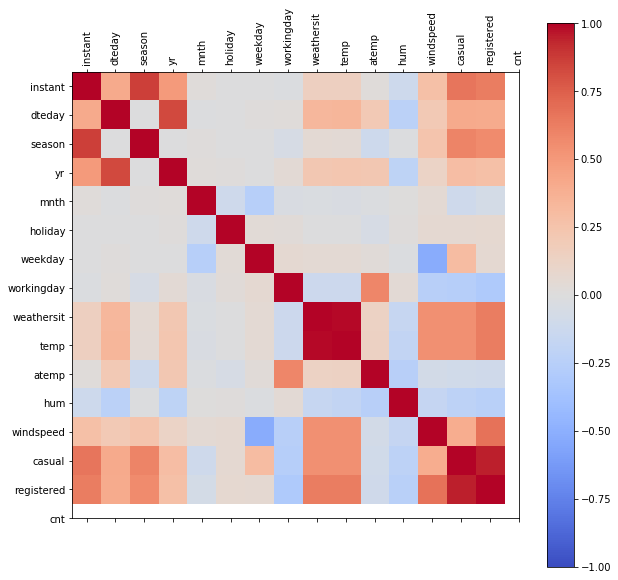

In [15]:
#Daily
plt.rcParams["figure.figsize"] = (10,10)
corr = daily_raw_data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(daily_raw_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(daily_raw_data.columns)
ax.set_yticklabels(daily_raw_data.columns)
plt.show()

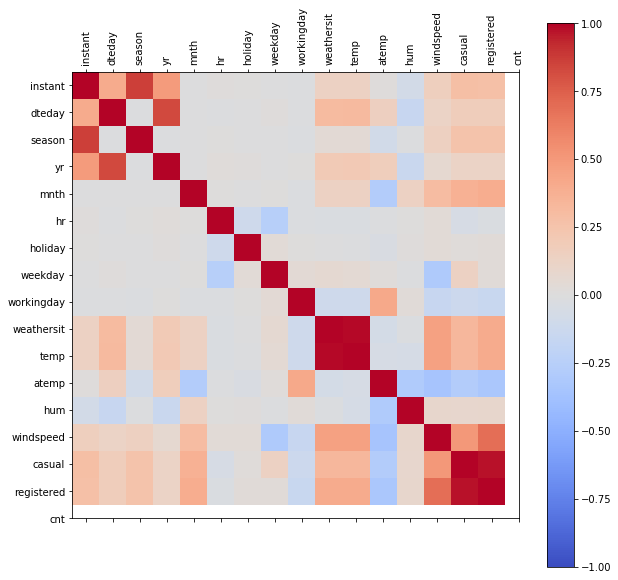

In [16]:
#Hourly
plt.rcParams["figure.figsize"] = (10,10)
corr = hourly_raw_data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(hourly_raw_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(hourly_raw_data.columns)
ax.set_yticklabels(hourly_raw_data.columns)
plt.show()

# Data transformation

### Converting `dteday` to date

In [11]:
daily_raw_data['dteday']=pd.to_datetime(daily_raw_data['dteday'], format='%Y-%m-%d')
hourly_raw_data['dteday']=pd.to_datetime(hourly_raw_data['dteday'], format='%Y-%m-%d')
hourly_raw_data['dteday'].head()

0   2011-01-01
1   2011-01-01
2   2011-01-01
3   2011-01-01
4   2011-01-01
Name: dteday, dtype: datetime64[ns]

## Add `isDaylight` and  `isNoon` for hourly data

In [12]:
hourly_raw_data['isDaylight']=0
hourly_raw_data['isNoon']=0

hourly_raw_data = hourly_raw_data.apply(lambda x: isDaylight(x), axis=1)
hourly_raw_data.head(20)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,isDaylight,isNoon
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,0,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,0,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,0,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,0,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,0,0
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,0,0
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,0,0
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3,0,0
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8,1,0
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,1,0


### Check (and fix?) skewness

In [13]:
check_skewness(hourly_raw_data, ['atemp','temp','hum','windspeed'])

atemp skewness p-value : -0.09042105336080838
temp skewness p-value : -0.00602036366695605
hum skewness p-value : -0.1112775438226877
windspeed skewness p-value : 0.5748555816221624

------

skewed_features:
[]


### One hot Encoding
For `season`, `weathersit`, `mnth`,`weekday`,`hr`

In [14]:
category  = ['season', 'weathersit', 'mnth','weekday','hr']
hourly = onehot_encode(num_name(hourly_raw_data),category)
hourly  = hourly.drop('instant',axis=1)


In [15]:
category  = ['season', 'weathersit', 'mnth','weekday']
daily= onehot_encode(num_name(daily_raw_data),category)
daily  = daily.drop('instant',axis=1)

In [16]:
hourly.dtypes

windspeed              float64
registered               int64
dteday          datetime64[ns]
workingday               int64
yr                       int64
temp                   float64
casual                   int64
cnt                      int64
isDaylight               int64
hum                    float64
holiday                  int64
isNoon                   int64
atemp                  float64
s_fall                   uint8
s_spring                 uint8
s_summer                 uint8
s_winter                 uint8
w_Acceptable             uint8
w_Bad                    uint8
w_Chaos                  uint8
w_Good                   uint8
m_1                      uint8
m_2                      uint8
m_3                      uint8
m_4                      uint8
m_5                      uint8
m_6                      uint8
m_7                      uint8
m_8                      uint8
m_9                      uint8
                     ...      
w_1                      uint8
w_2     

In [18]:
to_relative  = ['temp', 'atemp', 'hum','windspeed']
hourly = relative_values(hourly, to_relative)

### Genetic Programming

In [165]:
### Adding genetically programmed features to the data set 
## *** make sure to use the right target ... will start with cnt for now and will drop casual***
t_hourly = Genetic_P(hourly.drop(['registered','casual','dteday'],axis=1),'cnt')

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.13 0.08778209052574792       10 0.49892555056819776 0.5085881765868786      1.69m
   1     6.59 0.28057999150188595       12 0.6028509408073798 0.615472667877619      1.54m
   2     5.26 0.42440467591838904       12 0.6125676084747488 0.6247394441872826      1.45m
   3     7.83 0.44242670170391407       15 0.6513580447073263 0.6389678505607975      1.37m
   4    11.63 0.5124653016556951       19 0.6836654044386885 0.6782805950135526      1.30m
   5     14.7 0.5457222577468959       19 0.6840727177704434 0.6741204222552305      1.22m
   6    19.09 0.5724980531971047       52 0.7065516514989636 0.7086366540939636      1.16m
   7    24.73 0.6020096061768975       29 0.7157089218248321 0.7126907154158522      1.11m
   8    31.31 0.6203453

ADDING THE DATE AGAIN TO BE ABLE TO SEPARATE

In [166]:
hourly = pd.concat([pd.DataFrame(t_hourly ),pd.DataFrame(hourly['dteday'])],axis=1 ,join = 'inner') 

In [175]:
hourly

,0,1,2,3,4,5,6,7,8,9,...,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23,dteday
0,-0.033437,0.0000,-0.2821,-0.5700,0.2879,-1.0921,-0.5221,-0.2821,-0.5700,-0.033437,...,0,0,0,0,0,0,0,0,0,2011-01-01
1,-0.057793,0.0000,-0.3073,-0.5800,0.2727,-1.1073,-0.5273,-0.3073,-0.5800,-0.057793,...,0,0,0,0,0,0,0,0,0,2011-01-01
2,-0.057793,0.0000,-0.3073,-0.5800,0.2727,-1.1073,-0.5273,-0.3073,-0.5800,-0.057793,...,0,0,0,0,0,0,0,0,0,2011-01-01
3,0.026563,0.0000,-0.2221,-0.5100,0.2879,-0.9721,-0.4621,-0.2221,-0.5100,0.026563,...,0,0,0,0,0,0,0,0,0,2011-01-01
4,-0.510000,-1.0000,-0.5100,-0.5100,0.0000,-1.9721,-1.4621,-0.5100,-0.5100,-0.510000,...,0,0,0,0,0,0,0,0,0,2011-01-01
5,-0.002457,0.0000,-0.2524,-0.5100,0.2576,-1.0024,-0.4924,-0.2524,-0.5100,-0.002457,...,0,0,0,0,0,0,0,0,0,2011-01-01
6,-0.057793,0.0000,-0.3073,-0.5800,0.2727,-1.1073,-0.5273,-0.3073,-0.5800,-0.057793,...,0,0,0,0,0,0,0,0,0,2011-01-01
7,-0.152457,0.0000,-0.4024,-0.6600,0.2576,-1.2624,-0.6024,-0.4024,-0.6600,-0.152457,...,0,0,0,0,0,0,0,0,0,2011-01-01
8,1.026563,0.5379,0.7779,0.4900,1.2879,0.0279,0.5379,0.7779,0.4900,1.026563,...,0,0,0,0,0,0,0,0,0,2011-01-01
9,1.150339,0.5885,0.9085,0.5600,1.3485,0.1485,0.5885,0.9085,0.5600,1.150339,...,0,0,0,0,0,0,0,0,0,2011-01-01


In [28]:
# Test
regr = LinearRegression(fit_intercept =True)
regr.fit(X1_Train, y_reg_train)
y_pred = regr.predict(X1_Test)
r2_score(y_cnt_test,y_cas_test + y_pred)
##regr.score(X2_Test, y_cnt_test)

0.7381220462588927

### Correlation Matrix (After hot encoding)

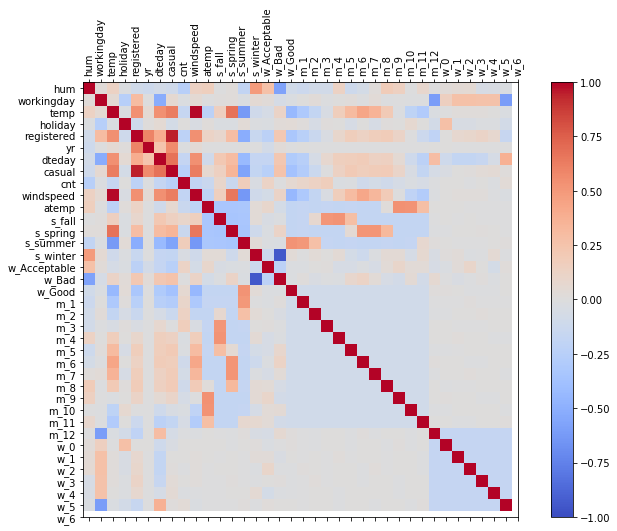

In [167]:
# Daily
plt.rcParams["figure.figsize"] = (12,8)
corr = daily.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(daily.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(daily.columns)
ax.set_yticklabels(daily.columns)
plt.show()

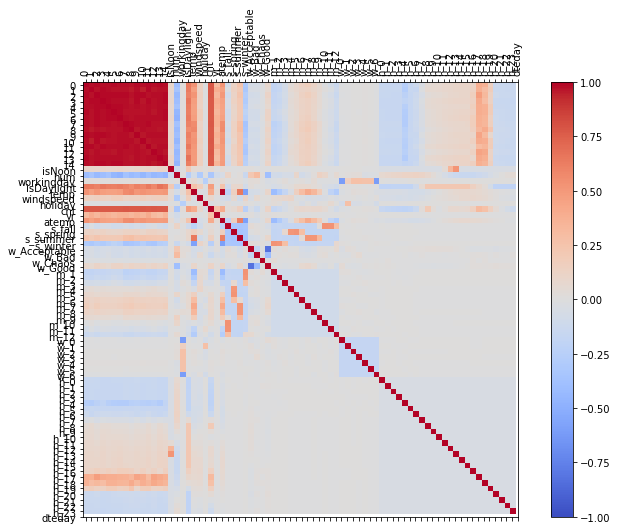

In [168]:
#Daily
plt.rcParams["figure.figsize"] = (12,8)
corr = hourly.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(hourly.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(hourly.columns)
ax.set_yticklabels(hourly.columns)
plt.show()

# Modeling (Baseline)

In [152]:
# X1_Train = hourly[hourly['dteday'] < '2012-10-01'].drop(['cnt','registered','dteday'],axis=1) ## CASUAL IN DATA
# X2_Train =  hourly[hourly['dteday'] < '2012-10-01'].drop(['cnt','casual','dteday'],axis=1) ## REGISTERED IN DATA 
# X3_Train = hourly[hourly['dteday'] < '2012-10-01'].drop(['cnt','casual','registered','dteday'],axis=1)## NONE OF THEM IN DATA

# X1_Test = hourly[hourly['dteday'] >= '2012-10-01'].drop(['cnt','registered','dteday'],axis=1)## CASUAL IN DATA
# X2_Test =  hourly[hourly['dteday'] >='2012-10-01'].drop(['cnt','casual','dteday'],axis=1)## REGISTERED IN DATA
# X3_Test = hourly[hourly['dteday'] >= '2012-10-01'].drop(['cnt','casual','registered','dteday'],axis=1)## NONE OF THEM IN DATA

# y_cas_train =hourly['casual'][hourly['dteday'] < '2012-10-01']
# y_cnt_train =hourly['cnt'][hourly['dteday'] < '2012-10-01']
# y_reg_train =hourly['registered'][hourly['dteday'] < '2012-10-01']

# y_cas_test =hourly['casual'][hourly['dteday'] >= '2012-10-01']
# y_cnt_test =hourly['cnt'][hourly['dteday'] >= '2012-10-01']
# y_reg_test =hourly['registered'][hourly['dteday'] >= '2012-10-01']


## Keeping this in case we want to reuse it later 

SINCE WE DECIDED TO WORK WITH NONE CASUAL OR REGISTERED IN THE DATA THIS IS THE NEW DATA SPLITTED

In [170]:
X_Train = hourly[hourly['dteday'] < '2012-10-01'].drop(['cnt','dteday'],axis=1)## NONE OF THst_EM IN DATA
X_Test = hourly[hourly['dteday'] >= '2012-10-01'].drop(['cnt','dteday'],axis=1)## NONE OF THEM IN DATA
Y_cnt_test =hourly['cnt'][hourly['dteday'] >= '2012-10-01']
Y_cnt_train =hourly['cnt'][hourly['dteday'] < '2012-10-01']

In [186]:
Y_cnt_test

15211     45
15212     18
15213     12
15214      7
15215     10
15216     36
15217    155
15218    483
15219    784
15220    340
15221    179
15222    272
15223    323
15224    305
15225    244
15226    329
15227    459
15228    856
15229    613
15230    516
15231    262
15232    218
15233    207
15234    105
15235     31
15236     11
15237      2
15238      5
15239     10
15240     43
        ... 
17349    125
17350    102
17351     72
17352     47
17353     36
17354     49
17355     34
17356     19
17357     11
17358      1
17359      3
17360      9
17361     40
17362     85
17363    196
17364    157
17365    120
17366    157
17367    224
17368    203
17369    247
17370    315
17371    214
17372    164
17373    122
17374    119
17375     89
17376     90
17377     61
17378     49
Name: cnt, Length: 2168, dtype: int64

In [32]:
# Create linear regression object
regr = LinearRegression(fit_intercept =True)
regr.fit(X2_Train, y_cas_train)
y_pred = regr.predict(X2_Test)
r2_score(y_cnt_test,y_reg_test + y_pred)
##regr.score(X2_Test, y_cnt_test)

0.9759256897023206

In [33]:
params = pd.Series(regr.coef_, index=X2_Train.columns)

Linear Models

In [171]:
##Linear Regression
lm_parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True]}
tscv = TimeSeriesSplit(n_splits=5)
lm = GridSearchCV(LinearRegression(),
                                 param_grid=lm_parameters,
                                 cv=tscv,return_train_score=True)

lm.fit(X_Train, Y_cnt_train)
lm.cv_results_
lm.score(X_Test, Y_cnt_test)

0.6713816425276811

In [187]:
##OrthogonalMatchingPursuit
omp_parameters = {'n_nonzero_coefs':[5,10,15],'fit_intercept':[True,False], 'normalize':[True,False]}
tscv = TimeSeriesSplit(n_splits=5)
omp = GridSearchCV(OrthogonalMatchingPursuit(),
                                 param_grid=omp_parameters,
                                 cv=tscv,return_train_score=True)

omp.fit(X_Train, Y_cnt_train)
omp.cv_results_
omp.score(X_Test, Y_cnt_test)

0.6579620172568988

Random Forest Model

In [195]:
tscv = TimeSeriesSplit(n_splits=5)
RF_parameters = {'n_estimators': [10, 30 ,100],
                                             'bootstrap': [True],
                                             'max_depth': [80, 100  ],
                                             'max_features': ['sqrt',16],
                                             'min_samples_leaf': [2,  5 , 8],
                                             'min_samples_split': [ 10 , 8 , 15],
                                            'random_state':[random_seed],
                                            'criterion':['mse']}
rf = GridSearchCV(RandomForestRegressor(),
                                 param_grid= RF_parameters,
                                 cv=tscv)
rf.fit(X_Train, Y_cnt_train)
rf.cv_results_
rf.score(X_Test, Y_cnt_test)

SyntaxError: invalid syntax (<ipython-input-195-68870c04025a>, line 14)

K- Nearest Neighbors

In [194]:
knn_parameters = {'n_neighbors':[5,10,15],'weights':['uniform'], 'algorithm':['auto'],'leaf_size':[20,30],
                  'p':[1,2],'metric':['minkowski']}
tscv = TimeSeriesSplit(n_splits=5)
knn = GridSearchCV(KNeighborsRegressor(),
                                 param_grid=knn_parameters,
                                 cv=tscv,return_train_score=True)

knn.fit(X_Train, Y_cnt_train)
print(knn.cv_results_)
knn.score(X_Test, Y_cnt_test)

{'mean_fit_time': array([0.03110557, 0.027985  , 0.02832241, 0.0273067 , 0.027984  ,
       0.02728066, 0.02647729, 0.02716188, 0.02851062, 0.02776585,
       0.02696509, 0.02681427]), 'std_fit_time': array([0.01513623, 0.01567389, 0.01528771, 0.01581133, 0.01483435,
       0.01477372, 0.01406854, 0.01586792, 0.01549563, 0.01542354,
       0.01492859, 0.01377503]), 'mean_score_time': array([0.55634141, 0.5928422 , 0.61608224, 0.64728789, 0.62534533,
       0.69802747, 0.51827292, 0.55724521, 0.56481676, 0.59571481,
       0.57825499, 0.64609342]), 'std_score_time': array([0.20854608, 0.19768287, 0.20340869, 0.2280077 , 0.22380984,
       0.24378811, 0.17763129, 0.16534683, 0.18518322, 0.19155834,
       0.19324285, 0.19613019]), 'param_algorithm': masked_array(data=['auto', 'auto', 'auto', 'auto', 'auto', 'auto', 'auto',
                   'auto', 'auto', 'auto', 'auto', 'auto'],
             mask=[False, False, False, False, False, False, False, False,
                   False, False,

0.7056549538147048